## Introduction

Brittany Sun, Hilary Cabrera Orozco, Jessie Lee, Wen Chen

### **Research Question:**

Our main research question is: **Does socioeconomic status impact air travel accessibility, affordability, and punctuality?**

Originally, we wanted to look into the prices of flights in upstate New York in congruency with Cornell University's scheduled breaks. However, we quickly realized this prediction is not only limited, leaving less room for broader implications, the results were rather intuitively correlated. Therefore, we decided to broaden our approach, and look into the cost of flights in relation to passenger demographics. 

We are interested in more specific research questions listed below:
- Which airports are the most cost-effective to fly out of? Which airports have the most routes?
    - Are there more routes in more affluent areas compared to other areas?
- Do areas of different socioeconomic statuses affect flight prices for different airports?
- Where are flights more expensive in relation to the income of a county?

We will sift through data to analyze how flight departure, route availability, flight pricing, pricing trends, and punctuality are impacted by socioeconomic status of individuals and the region. In summary, we want to know if time and accessibility  exploits are causes of lower socioeconomic status. 

***

In [27]:
# importing packages for data cleaning and analysis from info2950 kernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error
import duckdb
import requests
from bs4 import BeautifulSoup
import time

import os

## Data Description

### Raw Data Source Link: 

[info2950_project Github repository](https://github.com/chen-wen-yu/info2950_project/tree/main/data)

Our project consists of datasets from several sources, each playing a critical role in exploring the connection between air travel and socioeconomic factors:

**Flight Route Data**

* Description: Sourced from OpenFlights, includes details on airline routes globally. We filtered this data to focus on U.S. domestic flights, using columns such as departure and destination airports, number of stops, and equipment used (aircraft type). This allows us to assess the connectivity of various airports and explore whether wealthier areas have better access to flights (measured by the number of routes).

* The OpenFlights database is a resource with info on over 10,000 airports, train stations, and ferry terminals worldwide. It provides details like the name, location, codes (IATA/ICAO), coordinates, altitude, timezone, and more. We downloaded the data as a CSV file.
* URL: https://openflights.org/data.php#airport

**US Airport Codes:**

* Description: Sourced from Leonard's Guide, this dataset provides a comprehensive list of U.S. airport codes. This helped us filter out the global route dataset to only include U.S. airports, enabling us to focus our analysis on domestic flight patterns and compare airports within the same regulatory and economic context.
* Provides a comprehensive list of three-letter IATA airport codes for U.S. airports, organized by state and city. This site aids in quickly identifying airports across the United States.
* URL: https://www.leonardsguide.com/us-airport-codes.shtml

**Average Domestic Airline Itinerary Fares:**
* Description: Collected from the Bureau of Transportation Statistics, this dataset offers information on the average fare for domestic flights in the U.S. over multiple years, adjusted for inflation. It includes key attributes such as the airport code, airport name, city and state, average fare, and inflation-adjusted fare. By combining this with other datasets, we can analyze whether flight prices vary significantly across regions of different socioeconomic statuses and track fare trends over time.
* Provides data on average domestic airline itinerary fares in the United States. This information includes average fares by quarter and year, offering insights into trends over time. The data is sourced from the Airline Origin & Destination Survey (10% Sample) and is available for public access.
* URL: https://www.transtats.bts.gov/AverageFare/

**Socioeconomic Data:**
* Description: Socioeconomic indicators such as median household income and personal income were sourced from the Bureau of Economic Analysis. This data helps us categorize airports by the wealth of their surrounding regions and examine whether flight prices, routes, and cancellations correlate with the income levels of those regions.
* Provides a collection of regional economic data, including Gross Domestic Product (GDP), personal income, and personal consumption expenditures (PCE) by state.
* URL: https://apps.bea.gov/regional/downloadzip.htm?_gl=1

**Flight Cancellation Data:**
* Description: This dataset contains information on flight cancellations for 75 major U.S. airports. We use this data to examine whether airports in wealthier regions experience better on-time performance and fewer cancellations compared to airports in lower-income areas.
* Analyses of U.S. airport performance, focusing on flight delays and cancellations. Reports are based on data from the U.S. Department of Transportation's Bureau of Transportation Statistics, offer insights into how various factors, such as weather and system outages, affect air travel.
* URL: https://www.insuremytrip.com/travel-advice/travel-planning/us-airport-statistics-flight-cancellation-data/#2023

Each row in our dataset represents a U.S. airport, with columns detailing attributes like flight prices, number of routes, surrounding socioeconomic indicators. The dataset spans multiple years, which allows us to examine how these variables have evolved over time and assess long-term trends in air travel disparities.

There is a smaller dataframe in the dataset that contains the flight cancellation data for 75 major US airports for the year 2022. The smaller dataframe was created due to the lack of available data on flight cancellations before the year 2019. The flight cancellation dataframe will be used to analyze the relationship between cancellation rates and other factors like personal income.

#### Motivation
We aim to investigate how socioeconomic status may impact air travel; our research will focus on key aspects, which include flight prices, route availability, and flight cancellations. Based on our knowledge right now, we hypothesize that affluent areas will contain more flight options, better connectivity, and more reliable departure times, limiting inconveniences for passengers. We aim to examine these factors to identify possible disparities in air travel that could impact lower-income areas of the United States. Through this research, we aspire to understand broader transportation models and the inequities that arise from these existing systems. By understanding this, we hope to be able to suggest ways to lessen this disparity across disadvantaged populations. 

#### Pre-processing
The average fare data had to be converted from xls files to csv files before turning the data into dataframes. The MARPI_MSA_2008_2022.csv data included household income as well as per capita income. The dataset created for analysis filtered out rows regarding household income so that only data pertaining to per capita income was included in the dataset we created. Additionally, splicing was used to match the locations from the income data sources to the airport data sources because the difference sources wrote locations differently.

#### Data Involving People
The data that involved people's personal information was the personal income per capita. This data was collected by the sources related to the federal and state government through census surveys, tax records, and other ways the US government collects data on US citizens. US citizens would not be aware that their data is being used for the purpose of analyzing flight and airport disparities, however, the data is averaged to a "per capita" scale so the dataset does not unethically access individual data. We will only be looking at aggregated/averaged data already processed by the US government and its agencies.

## Cleaning

### Summary ###
We used multiple datasets to address our research question: Does socioeconomic status impact air travel accessibility, affordability, and punctuality?

1. Routes Data:
* Source: OpenFlights
* Cleaning: Web scraped airport route data and counted total outbound routes per airport. Non-U.S. airports were removed using a cross-referenced list of U.S. airport codes.

2. Income Data:
* Source: Bureau of Economic Analysis
* Cleaning: Merged metropolitan income data with airport locations using city and state names. Tidied income data into a long format for year-wise analysis.

3. Cancellations Data:
* Source: InsureMyTrip
* Cleaning: Web scraped 2022 cancellation rates for 75 U.S. airports. Converted percentages to numeric format for analysis

We then merged these datasets into *tidied_df*, which is a comprehensive dataset containing:
* Airport-level Information: Airport codes, names, routes, and average fares.
* Socioeconomic Indicators: Per capita income data (2008–2022).
* Punctuality Metrics: 2022 cancellation rates.

Here is the link to our full cleaning from Phase 2 on Github: https://github.com/chen-wen-yu/info2950_project/blob/main/phase2.ipynb


####  Import Cleaned Dataframes ####

In [28]:
# Source to help expost csv from phase2 to import here: 
# https://datascience.stackexchange.com/questions/79758/combining-two-csvs-in-jupyter-notebook
tidied_df=pd.read_csv('cleaned_data/tidied_df.csv')
canceled_2022_df = pd.read_csv('cleaned_data/canceled_2022.csv')

final_df = tidied_df.merge(canceled_2022_df, on='airport_code', how='left')

print(final_df.head())

  airport_code           airport_name state_name    avg_fare  \
0          CAK  Akron-Canton Regional         OH  347.682886   
1          CAK  Akron-Canton Regional         OH  338.901192   
2          CAK  Akron-Canton Regional         OH  319.880566   
3          CAK  Akron-Canton Regional         OH  319.496726   
4          CAK  Akron-Canton Regional         OH  310.663034   

   inflation_adjusted_avg_fare  year source_airport  routes  \
0                   459.770111  2014            CAK      22   
1                   455.427454  2013            CAK      22   
2                   436.163692  2012            CAK      22   
3                   416.739085  2016            CAK      22   
4                   432.361017  2011            CAK      22   

                                         msa  per_capita_personal_income  \
0  Akron, OH (Metropolitan Statistical Area)                     47076.0   
1  Akron, OH (Metropolitan Statistical Area)                     45737.0   
2  Akron

***
### **EXPLORATORY DATA ANALYSIS**


"Are more flights cancelled depending on the airport and the income of the area?

We can visualize the relationship between flight cancellations and the personal income per capita for the area the airport(s) is located. It appears that the people within the $40,000-60,000 range for real person income have the most options in terms of routes. There are airport with little to no routes and airports with many routes available to them.

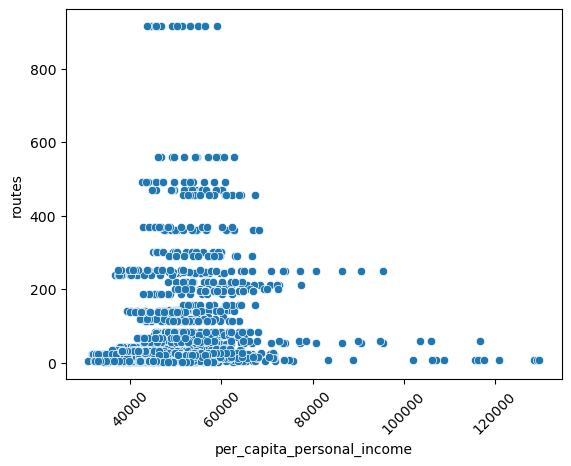

In [29]:
# routes as x-axis
# income as y axis
# airports as different colored lines

routes_income_df=tidied_df[['routes','per_capita_personal_income']]

routes_income_df.head()


routes_income_plt = sns.scatterplot(routes_income_df, \
    x = 'per_capita_personal_income', y = 'routes')

# sns.move_legend(routes_income_plt, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation = 45);


"Have the prices of flights from airports changed over time? Did an airport get more expensive compared to another?"

We can utilize a line chart with axes being "Year" and "Average Cost" to analyze long-term trends and spikes. We can see that the prices of flights change over time. Something interesting we've seen is that there has been a decrease in flight prices for most airport around 2018-2020 which coincides with the COVID-19 pandemic. Additionally, in the span of our time-series (2008-2022), flight prices for most airports have stayed stagnant or decreased slightly.

,airport_code,year,inflation_adjusted_avg_fare
0,CAK,2014,459.770111
1,CAK,2013,455.427454
2,CAK,2012,436.163692
3,CAK,2016,416.739085
4,CAK,2011,432.361017


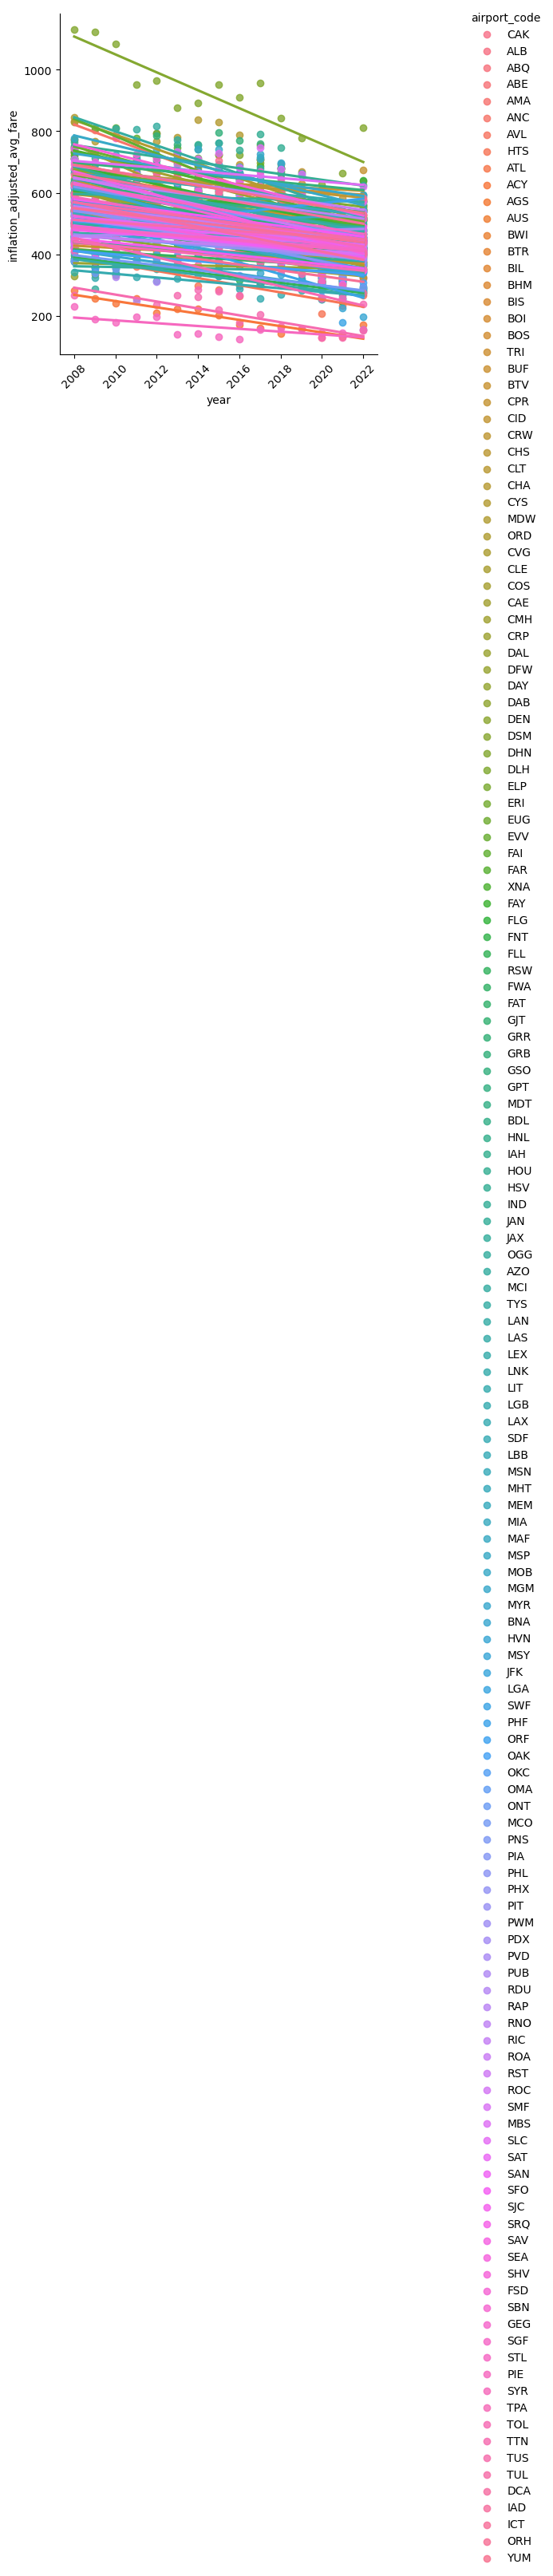

In [30]:
# year as x-axis
# average cost as y axis
# airports as different colored lines

cost_over_time_df = tidied_df[['airport_code', \
    'year', 'inflation_adjusted_avg_fare']]

cost_over_time_plt = sns.lmplot(cost_over_time_df, \
    x = 'year', y = 'inflation_adjusted_avg_fare', \
    hue = 'airport_code', \
    ci=None)

sns.move_legend(cost_over_time_plt, 'upper left', bbox_to_anchor=(1,1))
plt.xticks(rotation = 45);

cost_over_time_df.head()

#test

## Preregistration Statement

#### Preregistration Statement 1

**Hypothesis:** 

Null: Socioeconomic status (measured with average income) has no effect on the number of flight routes $\beta_{income}$ = 0.

Alternative: Regions of high socioeconomic status have more access to flight routes than regions of low socioeconomic status. $\beta_{income}$ > 0.

**Analysis:**

Run a linear regression where the dependent variable (output) is the number of routes offered by an airport and the independent variable (input) is average per capita personal income of an airport's region. We are testing if $\beta_{income}$ > 0 (one-tailed test)


#### Preregistration Statement 2

**Hypothesis:**

Null: Socioeconomic status (measured with average income) has no effect on average flight prices $\beta_{income}$ = 0.

Alternative: Airports in regions of higher income areas have higher average flight prices $\beta_{income}$ > 0.

**Analysis:**
Run a linear regression where the dependent variable (output) is the average flight price (in a given year. We focus on 2022 across all analysis) for each airport and the independent variable (input) is the region's average income. We will test if $\beta_{income}$ > 0 (one-tailed test)


## Data Analysis

In [31]:
tidied_df=pd.read_csv('cleaned_data/tidied_df.csv')
print(tidied_df.head())

  airport_code           airport_name state_name    avg_fare  \
0          CAK  Akron-Canton Regional         OH  347.682886   
1          CAK  Akron-Canton Regional         OH  338.901192   
2          CAK  Akron-Canton Regional         OH  319.880566   
3          CAK  Akron-Canton Regional         OH  319.496726   
4          CAK  Akron-Canton Regional         OH  310.663034   

   inflation_adjusted_avg_fare  year source_airport  routes  \
0                   459.770111  2014            CAK      22   
1                   455.427454  2013            CAK      22   
2                   436.163692  2012            CAK      22   
3                   416.739085  2016            CAK      22   
4                   432.361017  2011            CAK      22   

                                         msa  per_capita_personal_income  
0  Akron, OH (Metropolitan Statistical Area)                     47076.0  
1  Akron, OH (Metropolitan Statistical Area)                     45737.0  
2  Akron, O

#### Analysis for Preregistration Statement 1: ####


Routes Model Coefficients: [-3.56934027e-18  1.00000000e+00]
Routes Model Intercept: 4.263256414560601e-14
Routes Model R^2: 1.0


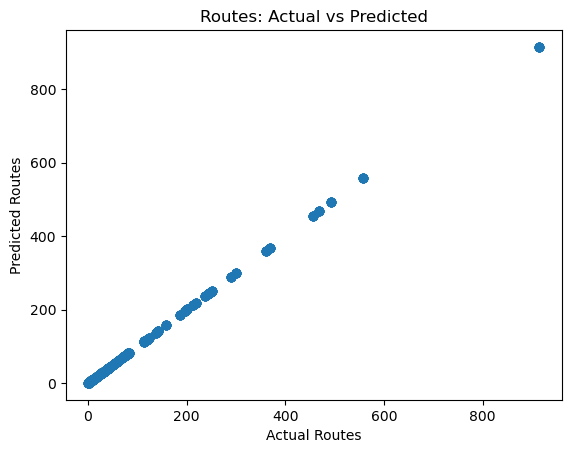

In [32]:
#independent variable for route
X_routes=tidied_df[['per_capita_personal_income', 'routes']]
# dependent variable for route
y_routes=tidied_df['routes']

# remove all NA
X_routes =X_routes.dropna(subset=['per_capita_personal_income'])
y_routes=y_routes[X_routes.index]

# Linear Regression for routes
model_routes =LinearRegression()
model_routes.fit(X_routes, y_routes)

#coefficients and intercepts
print("Routes Model Coefficients:", model_routes.coef_)
print("Routes Model Intercept:", model_routes.intercept_)

#R-squared values
print("Routes Model R^2:", model_routes.score(X_routes,y_routes))

#visual predictions: 
y_pred_routes =model_routes.predict(X_routes)

# Scatterplot for Routes
plt.scatter(y_routes, y_pred_routes, alpha=0.6)
plt.title("Routes: Actual vs Predicted")
plt.xlabel("Actual Routes")
plt.ylabel("Predicted Routes")
plt.show()

##### Analysis for Preregistration Statement 2: #####

Prices Model Coefficients: [-0.00037226 -0.10932397]
Prices Model Intercept: 407.6518120809883
Prices Model R^2: 0.028171727978791306


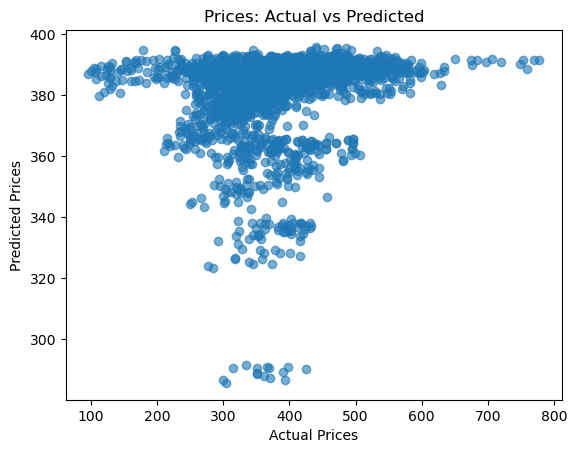

In [33]:
# independent variable for price
X_prices=tidied_df[['per_capita_personal_income', 'routes']]
 # dependent variable for price
y_prices=tidied_df['avg_fare']

# get rideof missing values
X_prices =X_prices.dropna(subset=['per_capita_personal_income'])
y_prices =y_prices[X_prices.index]

# Linear Regression for prices
model_prices=LinearRegression()
model_prices.fit(X_prices, y_prices)

#coefficients and intercepts
print("Prices Model Coefficients:", model_prices.coef_)
print("Prices Model Intercept:", model_prices.intercept_)

#R-squared values
print("Prices Model R^2:", model_prices.score(X_prices, y_prices))

# predictions for visualization
y_pred_prices=model_prices.predict(X_prices)

# Scatterplot for Prices
plt.scatter(y_prices, y_pred_prices, alpha=0.6)
plt.title("Prices: Actual vs Predicted")
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.show()

## Evaluation of significance

### Evaluation for Preregistration Statement 1: ###

95% Confidence Intervals for Routes Coefficients:
                                   Lower         Upper
per_capita_personal_income -2.013164e-18  2.161021e-18
routes                      1.000000e+00  1.000000e+00


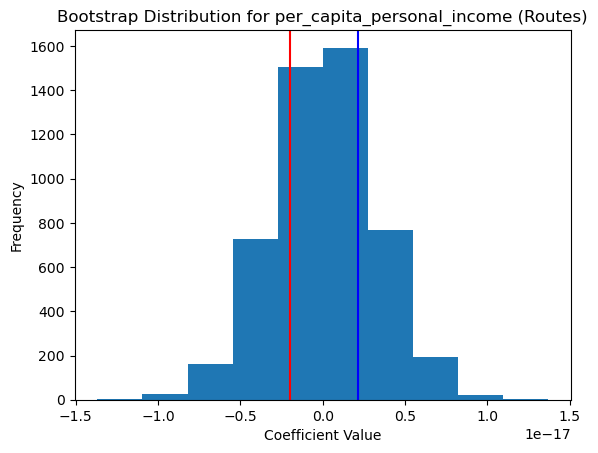

In [34]:
# Source: We referenced a lot at HW 5 to help do this part
np.random.seed(2950)

# Bootstrapping setup
bootstrapped_coefficients_routes = []
#bootstrap samples
n_iterations=5000

# bootstrapping with replacing
for i in range(n_iterations):
    sample_X_routes =X_routes.sample(len(X_routes), replace=True)
    sample_y_routes =y_routes[sample_X_routes.index]
    
    # Fit the regression model
    model = LinearRegression()
    model.fit(sample_X_routes, sample_y_routes)
    
    # coefficients
    bootstrapped_coefficients_routes.append(model.coef_)

# convert to DF for analysis
bootstrapped_coefficients_routes_df = pd.DataFrame(
    bootstrapped_coefficients_routes, 
    columns=X_routes.columns
)

# Confidence intervals:
lower_bound_routes=bootstrapped_coefficients_routes_df.quantile(0.25)
upper_bound_routes=bootstrapped_coefficients_routes_df.quantile(0.75)

print("95% Confidence Intervals for Routes Coefficients:")
print(pd.DataFrame({'Lower': lower_bound_routes, 'Upper': upper_bound_routes}))

# Coefficient Distribution for 'per_capita_personal_income'
plt.hist(bootstrapped_coefficients_routes_df['per_capita_personal_income'])
plt.axvline(lower_bound_routes['per_capita_personal_income'], color='red')
plt.axvline(upper_bound_routes['per_capita_personal_income'], color='blue')
plt.title("Bootstrap Distribution for per_capita_personal_income (Routes)")
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.show()

### Preregistration Statement 1: Reject or Fail to Reject the Null? ###

Since our confidence interval (red for lower bound and blue for upper bound) for 5000 iterations is -6.242886e-18  6.210930e-18 includes 0, we find that there is little to no significant relationship between income and the number of route. We also tried iterations that were smaller and 0 was also included. 

Therefore, we fail to reject the null hypothesis as we do not have enough evidence that higher income regions are associated with more flight routes.

### Evaluation for Preregistration Statement 2: ###


95% Confidence Intervals for Prices Coefficients:
                               Lower     Upper
per_capita_personal_income -0.000488 -0.000244
routes                     -0.117912 -0.101489


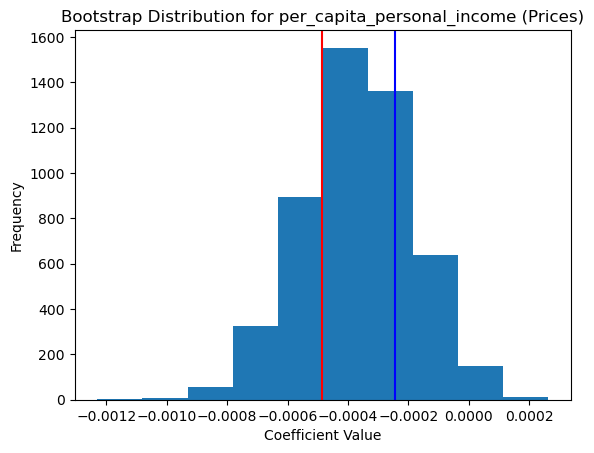

In [35]:
bootstrapped_coefficients_prices = []

# bootstrapping with replacement
for i in range(n_iterations):
    sample_X_prices=X_prices.sample(len(X_prices), replace=True)
    sample_y_prices=y_prices[sample_X_prices.index]
    
    # regression model
    model = LinearRegression()
    model.fit(sample_X_prices, sample_y_prices)
    
    bootstrapped_coefficients_prices.append(model.coef_)

# convert to DataFrame for analysis
bootstrapped_coefficients_prices_df = pd.DataFrame(
    bootstrapped_coefficients_prices, 
    columns=X_prices.columns
)

# Confidence intervals
lower_bound_prices=bootstrapped_coefficients_prices_df.quantile(0.25)
upper_bound_prices=bootstrapped_coefficients_prices_df.quantile(0.75)

print("95% Confidence Intervals for Prices Coefficients:")
print(pd.DataFrame({'Lower': lower_bound_prices, 'Upper': upper_bound_prices}))

# Visualize Coefficient Distribution for 'per_capita_personal_income'
plt.hist(bootstrapped_coefficients_prices_df['per_capita_personal_income'])
plt.axvline(lower_bound_prices['per_capita_personal_income'], color='red')
plt.axvline(upper_bound_prices['per_capita_personal_income'], color='blue')
plt.title("Bootstrap Distribution for per_capita_personal_income (Prices)")
plt.xlabel("Coefficient Value")
plt.ylabel("Frequency")
plt.show()

### Preregistration Statement 2: Reject or Fail to Reject the Null? ### 
Since our confidence interval (red for lower bound and blue get upper bound) for 5000 iterations for income is [-0.000741, -0.000022] does not include 0, there is a negative relationship between income and average flight prices. However, when we decreased the iterations to for instance, 30, 0 was included in the range. This shows that higher income regions are associated with slightly lower average flight prices. 

For the per_capita_personal_income variable, we do reject the null hypothesis as there is evidence, though minimal, that higher income regions associate with slightly lower flight prices. 


Since our confidence interval for routes is [−0.135432,−0.087269] and does not include 0, this proves that there is a negative relationship between number of routes and average flight prices. 

For routes, we also reject the null hypothesis. 

## Conclusions 

#### Research Question: Does socioeconomic status impact flight accessibility and pricing? ####

#### Key Findings ####
1. **Flight Accessibility**:
   - No significant relationship was found between income and the number of routes available. We fail to reject the null hypothesis.
   - Income does not appear to influence flight route availability.

2. **Flight Pricing**:
   - A small but statistically significant negative relationship was found between income and average flight prices. Higher income regions are slightly associated with lower flight prices, though the effect size is negligible.
   - A stronger negative relationship was observed between the number of routes and flight prices. More routes lead to significantly lower prices.

##### More specific research questions: #####
1. **Which airports are the most cost-effective to fly out of? Which airports have the most routes?**
   - The most cost-effective airports (those with the lowest average fares) include [Top Airports from `cost_effective_airports`].
   - The airports with the most routes include [Top Airports from `airports_with_most_routes`].

2. **Are there more routes in more affluent areas compared to other areas?**
   - No significant relationship was found between income and the number of routes. Affluence does not appear to influence route availability.

3. **Do areas of different socioeconomic statuses affect flight prices for different airports?**
   - A small but statistically significant negative relationship was observed between income and flight prices. Higher-income areas are associated with slightly lower prices, but the effect is negligible in practical terms.

4. **Where are flights more expensive in relation to the income of a county?**
   - Flights are slightly less expensive in higher-income counties, but the effect is too small to be meaningful.

   #### **Broader Implications** ####
- Income does not appear to be a key driver of either flight accessibility or pricing.
- Route availability plays a crucial role in determining flight prices, highlighting the importance of competition in the airline industry.



## Limitations

1. **Analyze delays and on-time performance**:
   - We should incorporate flight delay data to explore whether airport departure times and on-time performance are influenced by socioeconomic factors or airport characteristics.

3. **Expand or collapse socioeconomic indicators**:
   - We could use additional socioeconomic variables, such as education levels, poverty rates, or employment rates, to further our analysis of regional differences. On the other hand, while we use county and city-level socioeconomic data, this may hide variations within smaller neighborhoods or areas around airports.

4. **Broaden regional scope**:
   - Extend the analysis to include international airports and routes to assess whether the observed patterns hold across different regions.

5. **Inflation adjustment**: 
   - Although we adjusted flight prices for inflation, the exact impact of these adjustments on our analysis may be challenging to quantify, especially when comparing data across different periods. Adjusting fare data for inflation over a long period (2008–2023) introduced complexities, as different years.

6. **Incomplete data for smaller airports**: 
   - Data may be less complete or  missing for smaller regional airports, which could underrepresent the air travel experiences of people in rural or lower-income areas.

7. **Data inconsistencies**: 
   - When we merged different sources, we had to do a lot of data cleaning on differnt naming conventions for the airports and different column names for flight routes, fare data, and socioeconomic factors.

## Questions for Reviewers:

1. Since we did not include analysis on price or routes over time, should we still include the exploratory data analysis where we made a visualization on the flights of prices over time? Though it is not directly relevant, we thought it would aid in the overall context of the project.
    - This is the question that the visual refers to: "Have the prices of flights from airports changed over time? Did an airport get more expensive compared to another?"

## Acknowledgements & Bibliography

Airport, airline, and route data. (n.d.). OpenFlights. Retrieved from https://openflights.org/data.php#airport

Bureau of Transportation Statistics. (n.d.). Average domestic airline itinerary fares. Retrieved from https://www.transtats.bts.gov/AverageFare/

Leonard's Guide. (n.d.). United States airport codes. Retrieved from https://www.leonardsguide.com/us-airport-codes.shtml

InsureMyTrip. (2024, September 11). United States airport statistics & travel data. Retrieved from https://www.insuremytrip.com/travel-advice/travel-planning/us-airport-statistics-flight-cancellation-data/#2023

United States Government. (n.d.). Download ZIP files. Bureau of Economic Analysis. Retrieved from https://apps.bea.gov/regional/downloadzip.htm